In [ ]:
import mitsuba as mi
# Set Mitsuba variant
mi.set_variant("llvm_ad_mono_polarized")
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMapSolver

from scene_objects import create_scene_objects, gather_bboxes
from plotter import create_jammer_animation, visualize_scene_collisions
from archive.motion_engine import MotionEngine
from archive.motion_strategies import RandomWalkStrategy, RandomWalkConfig

%load_ext autoreload
%autoreload 2

In [ ]:
from archive.motion_engine import MotionEngine
from archive.motion_strategies import InteractiveStrategy, InteractivePathConfig
import numpy as np

In [3]:
scene_path = r"/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/ChicagoMarionaClean.xml"
meshes_path = r"/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/meshes"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)
scene.frequency = 1.57542e9 # L1 frequency in Hz
buildings = gather_bboxes(meshes_path)

Processed 792 unique structures.


In [9]:
max_x, max_y = 0, 0
for b in buildings:

    if abs(b['min'][0]) > max_x:
        max_x = b['min'][0]
    if abs(b['max'][0]) > max_x:
        max_x = b['max'][0]
    if abs(b['min'][1]) > max_y:
        max_y = b['min'][1]
    if abs(b['max'][1]) > max_y:
        max_y = b['max'][1]

print(f"Map size: ({max_x} m, {max_y} m)")
    

Map size: (536.6615600585938 m, 581.457275390625 m)


In [ ]:
transmitter_config = [
    {"name": "Jammer1", "position": [200, -200, 0.0], "color": [1.0, 0.0, 0.0]},
    {"name": "Jammer2", "position": [-200, 200, 0.0], "color": [0.0, 0.0, 1.0]}
]

bounds, map_center, map_size, cell_size = create_scene_objects(
    scene,
    transmitters_config=transmitter_config,
    map_bounds={'x': [-600, 600], 'y': [-600, 600]},
    cell_size=(20, 20),
    z_height=0.0
)
map_width, map_height = map_size

Padded 'Jammer2' from 75 to 100 (mode: pad_start)
Starting simulation for 100 steps...
Step 0: Jammer1 is at [ 200. -200.    0.]
Step 0: Jammer2 is at [-200.  200.    0.]


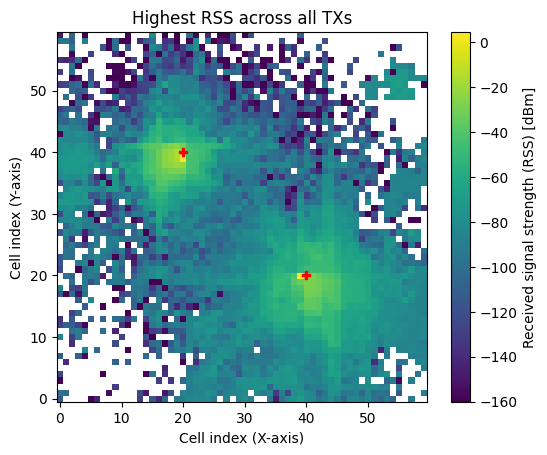

Step 20: Jammer1 is at [ 132.11441404 -289.0235389     0.        ]
Step 20: Jammer2 is at [-200.  200.    0.]
Step 40: Jammer1 is at [ 157.6292623  -287.30854603    0.        ]
Step 40: Jammer2 is at [-180.15544519  171.1747673     0.        ]
Step 60: Jammer1 is at [ 201.81517614 -339.48146863    0.        ]
Step 60: Jammer2 is at [-139.21324617  159.56881356    0.        ]
Step 80: Jammer1 is at [ 232.64393    -329.16971144    0.        ]
Step 80: Jammer2 is at [-157.08472071  146.18284502    0.        ]


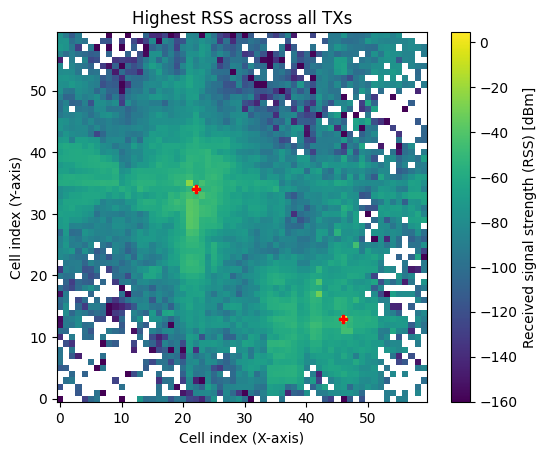

In [ ]:
# 1. Setup the Engine
engine = MotionEngine(scene=scene, obstacles=buildings, bounds=bounds)

# 2. Define the Strategy
random_walk = RandomWalkStrategy()

# 3. Configure and Add Jammer 1
# Jammer 1 moves 100 steps and stays at the last position if others continue
jammer1_config = RandomWalkConfig(
    starting_position=transmitter_config[0]['position'],
    num_steps=100,
    step_size=25,
    time_step=0.1,
    random_seed=123
)

engine.add_path(
    jammer_id="Jammer1", 
    strategy=random_walk, 
    config=jammer1_config, 
    padding_mode='pad_end'
)

# 4. Configure and Add Jammer 2
# Jammer 2 only moves for 50 steps and starts at step 50 (padded at start)
jammer2_config = RandomWalkConfig(
    starting_position=transmitter_config[1]['position'],
    num_steps=75,
    step_size=20.0,
    time_step=0.1,
    random_seed=123
)

engine.add_path(
    jammer_id="Jammer2", 
    strategy=random_walk, 
    config=jammer2_config, 
    padding_mode='pad_start'
)

# 5. Harmonize path lengths
# This ensures all jammers have the same number of steps based on the longest path
engine.finalize_paths()

# 6. Run Simulation Loop
total_steps = engine.get_max_path_length()
print(f"Starting simulation for {total_steps} steps...")

rm_solver = RadioMapSolver()
tx_power_dbm = 30.0
tx_power_linear = 10**(tx_power_dbm / 10.0) / 1000.0 # Convert dBm to Watts
precomputed_rss_list = []

for step in range(total_steps):
    # Update the actual Sionna scene transmitter positions
    engine.update_scene_transmitters(step)
    
    # Retrieve current positions for logging or custom logic
    current_positions = engine.get_all_positions_at_step(step)
    
    if step % 20 == 0:
        print(f"Step {step}: Jammer1 is at {current_positions['Jammer1']}")
        print(f"Step {step}: Jammer2 is at {current_positions['Jammer2']}")

    # Compute radio map
    rm = rm_solver(
        scene,
        max_depth=50,                   # Maximum number of ray-scene interactions (subject to change)
        samples_per_tx=10**6,           # More samples = less noise but more memory
        cell_size=cell_size,            # Resolution of the radio map
        center=map_center,              # Center of the coverage area
        size=[map_width, map_height],   # Total size of the radio map
        orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
        diffraction=True,
        refraction=True,
        edge_diffraction=True
    )

    path_gain_linear = rm.path_gain.numpy()
    
    # Calculate Aggregate RSS (Sum of power from all jammers in Watts)
    # RSS_linear = Sum(PathGain_linear * TxPower_linear)
    aggregate_rss_watts = np.sum(path_gain_linear * tx_power_linear, axis=0)
    
    # Convert to dBm for visualization
    # 10 * log10(Watts) + 30
    aggregate_rss_dbm = 10 * np.log10(np.maximum(aggregate_rss_watts, 1e-15)) + 30
    
    precomputed_rss_list.append(aggregate_rss_dbm)
    
    if step == 0 or step == total_steps - 1:
        # Display radio map
        rm.show(metric="rss", tx=None, show_tx=True, vmin=-160)
        plt.show()

In [7]:
create_jammer_animation(
    rss_list=precomputed_rss_list,
    engine=engine,
    buildings=buildings,
    map_size=map_size,
    map_center=map_center,
)

Animation with layout saved to: jammer_animation.gif


Processed 792 unique structures.


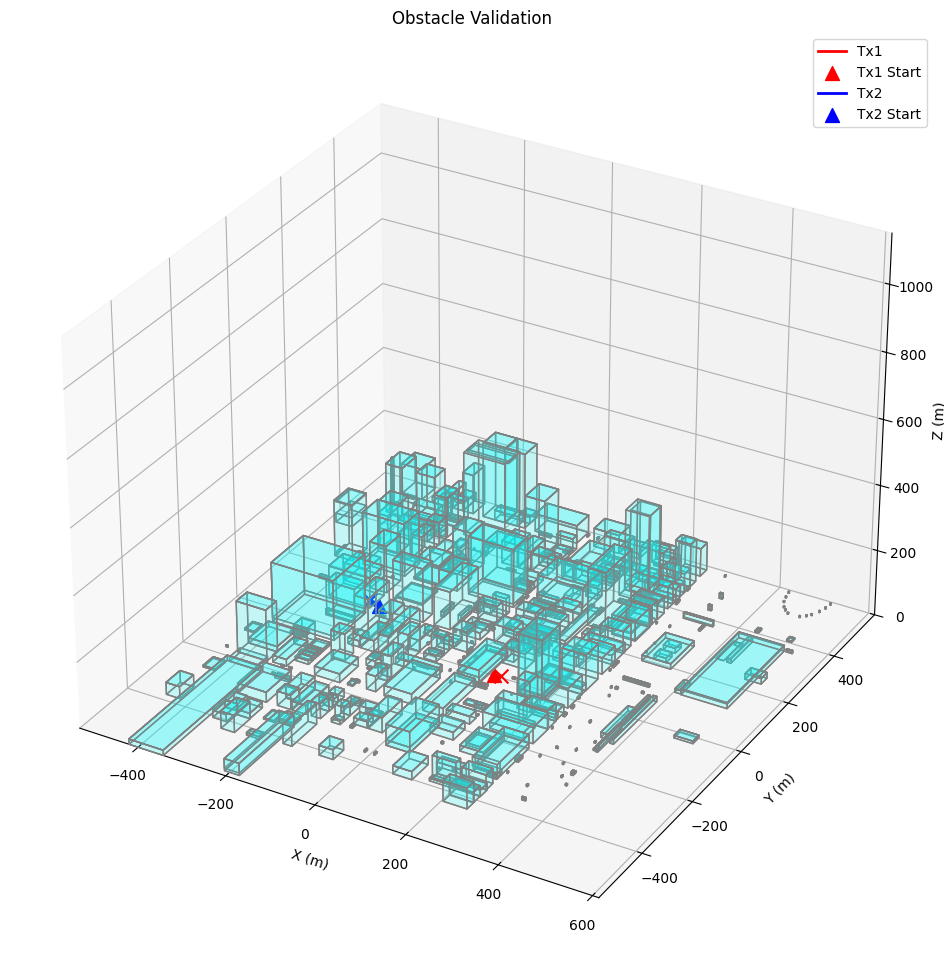

In [ ]:

visualize_scene_collisions(building_data, engine.jammer_paths)

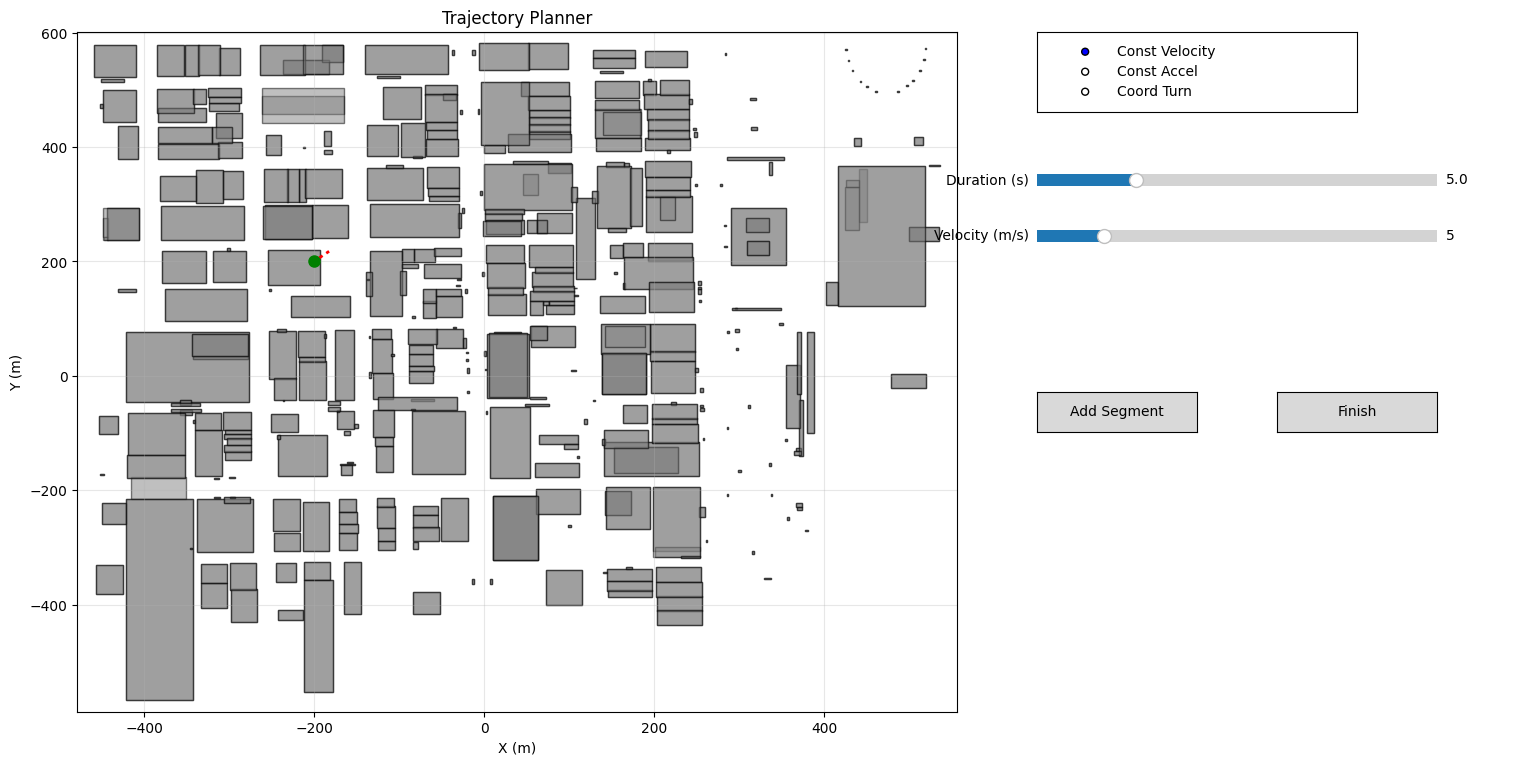

No path generated. Returning stationary path.
Created path with None segments.


In [6]:
engine = MotionEngine(scene=scene, obstacles=buildings, bounds=bounds)

config = InteractivePathConfig(
    starting_position=np.array([-200.0, 200.0, 0]), 
    initial_heading=45.0, # Start facing North-East
    time_step=0.1
)

strategy = InteractiveStrategy()

path, metadata = engine.add_path("Jammer1_interactive", strategy, config)

print(f"Created path with {metadata.get('num_segments')} segments.")